# Home Cage Dopamine Analysis

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

from hc_extension import *
from bouts_extension import *

In [2]:
# NAc: #15616F
# mPFC: #FFAF00

# NAc
nac_experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac"
nac_csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac_csvs"
nac_color = '#15616F'


# mPFC
mpfc_experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc"
mpfc_csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc_csvs"
mpfc_color = '#FFAF00'

In [3]:
# groups csv + experiment data into one variable
nac_exp = Experiment(nac_experiment_path, nac_csv_base_path)

mpfc_exp = Experiment(mpfc_experiment_path, mpfc_csv_base_path)

# batch process the data, removing the specified time segments for subjects
nac_exp.default_batch_process()

mpfc_exp.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\n5-240823-085032\Notes.txt
read from t=0s to t=1789.26s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\n6-240823-101436\Notes.txt
read from t=0s to t=1793.07s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\n7-240824-062103\Notes.txt
read from t=0s to t=1803.56s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\nn1-250120-063024\Notes.txt
read from t=0s to t=1833.87s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\nn2-250120-072910\Notes.txt
read from t=0s to t=1774.16s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac\nn3-250121-074834\Notes.txt
read f

In [4]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

nac_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

mpfc_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
nac_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  mode='standard')

mpfc_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  mode='standard')

Processing behaviors for n5-240823-085032...
Processing behaviors for n6-240823-101436...
Processing behaviors for n7-240824-062103...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn2-250120-072910...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn4-250121-084228...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035..

### Peak standard z-score

In [5]:
nac_exp_da_dict = get_trial_dataframes(nac_exp)
mpfc_exp_da_dict = get_trial_dataframes(mpfc_exp)

In [6]:
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']

nac_da_metadata_df = create_da_metrics_dataframe(nac_exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

mpfc_da_metadata_df = create_da_metrics_dataframe(mpfc_exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

In [7]:
# Copy original DataFrame
nac_ordered_df = nac_da_metadata_df.copy()

mpfc_ordered_df = mpfc_da_metadata_df.copy()

desired_bout_order = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]

# 1. Filter and reorder Bout as categorical
nac_ordered_df = nac_ordered_df[nac_ordered_df["Bout"].isin(desired_bout_order)].copy()
nac_ordered_df["Bout"] = pd.Categorical(nac_ordered_df["Bout"], categories=desired_bout_order, ordered=True)

mpfc_ordered_df = mpfc_ordered_df[mpfc_ordered_df["Bout"].isin(desired_bout_order)].copy()
mpfc_ordered_df["Bout"] = pd.Categorical(mpfc_ordered_df["Bout"], categories=desired_bout_order, ordered=True)

In [8]:
nac_ordered_df.head()

,Subject,Bout,Behavior,AUC,Max Peak,Mean Z-score
0,n5,Short_Term-1,Investigation,185.091739,9.865375,2.800204
1,n5,Novel-1,Investigation,15.622659,4.401797,3.551182
2,n5,Short_Term-2,Investigation,1.191829,0.571327,0.350630
3,n5,Long_Term-1,Investigation,16.355555,4.430108,1.947396
4,n6,Short_Term-1,Investigation,21.350400,5.633613,4.543470


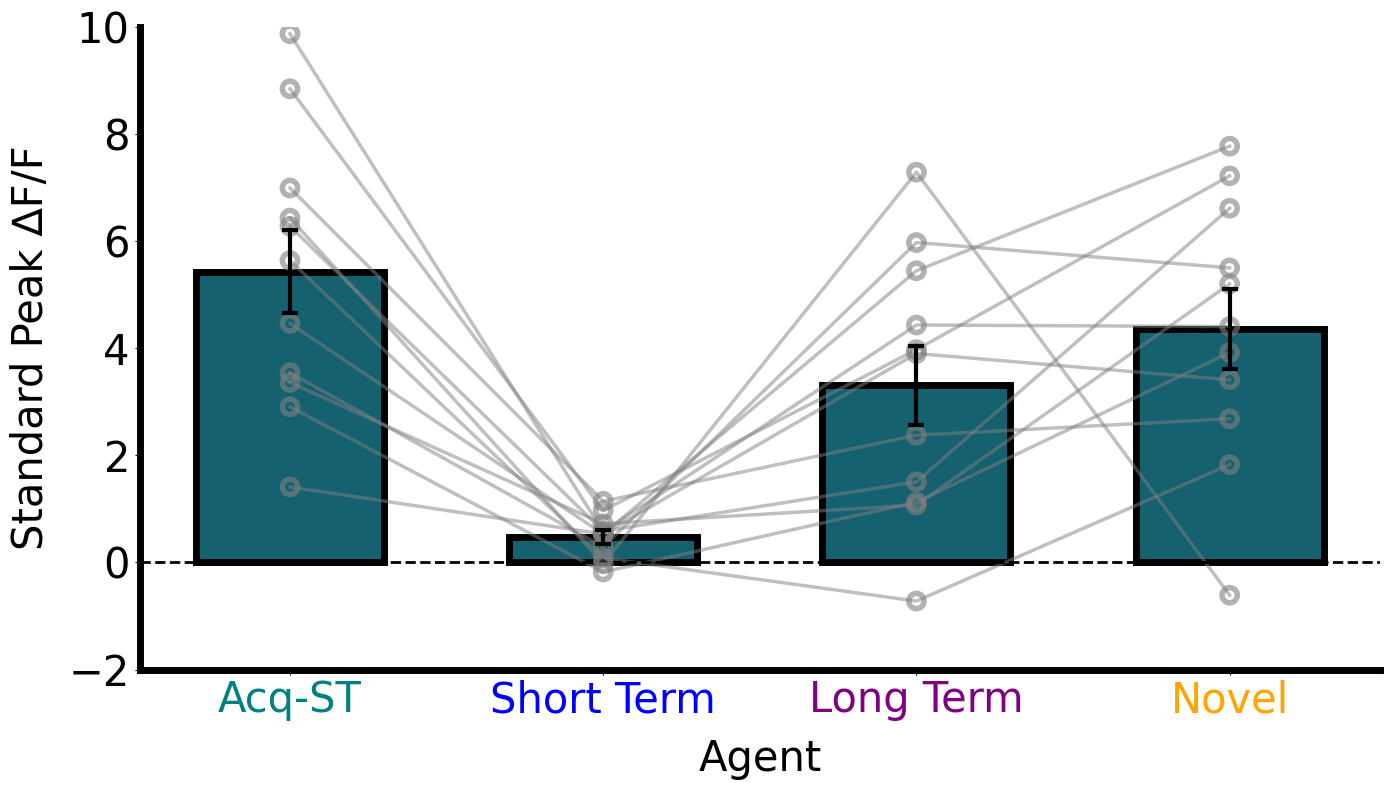


Paired t-test results:
                  comparison  n  t_stat  p_value  cohen_d
Short_Term-1 vs Short_Term-2 11  6.6679   0.0001   2.0105
 Short_Term-1 vs Long_Term-1 11  2.1200   0.0600   0.6392
     Short_Term-1 vs Novel-1 11  1.0025   0.3397   0.3023
 Short_Term-2 vs Long_Term-1 11 -3.7768   0.0036  -1.1387
     Short_Term-2 vs Novel-1 11 -5.5077   0.0003  -1.6606
      Long_Term-1 vs Novel-1 11 -0.9898   0.3456  -0.2984


In [20]:
nac_pivot_df, nac_stats_df = plot_behavior_across_bouts_no_identities(
    metadata_df=nac_ordered_df,
    y_col="Max Peak",
    ylabel="Standard Peak ∆F/F",
    xlabel="Agent",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-2, 10),
    yticks_increment=2,
    bar_color=nac_color,
    figsize=(14, 8),
    save=None,
    save_name ="mDA",
    title=None
)

In [ ]:
bon_results = apply_multiple_comparisons(
    nac_stats_df,
    method='holm',
    alpha=0.05,
    comparisons=["s1-1 vs s1-2", "s1-5 vs s2-1"]
)

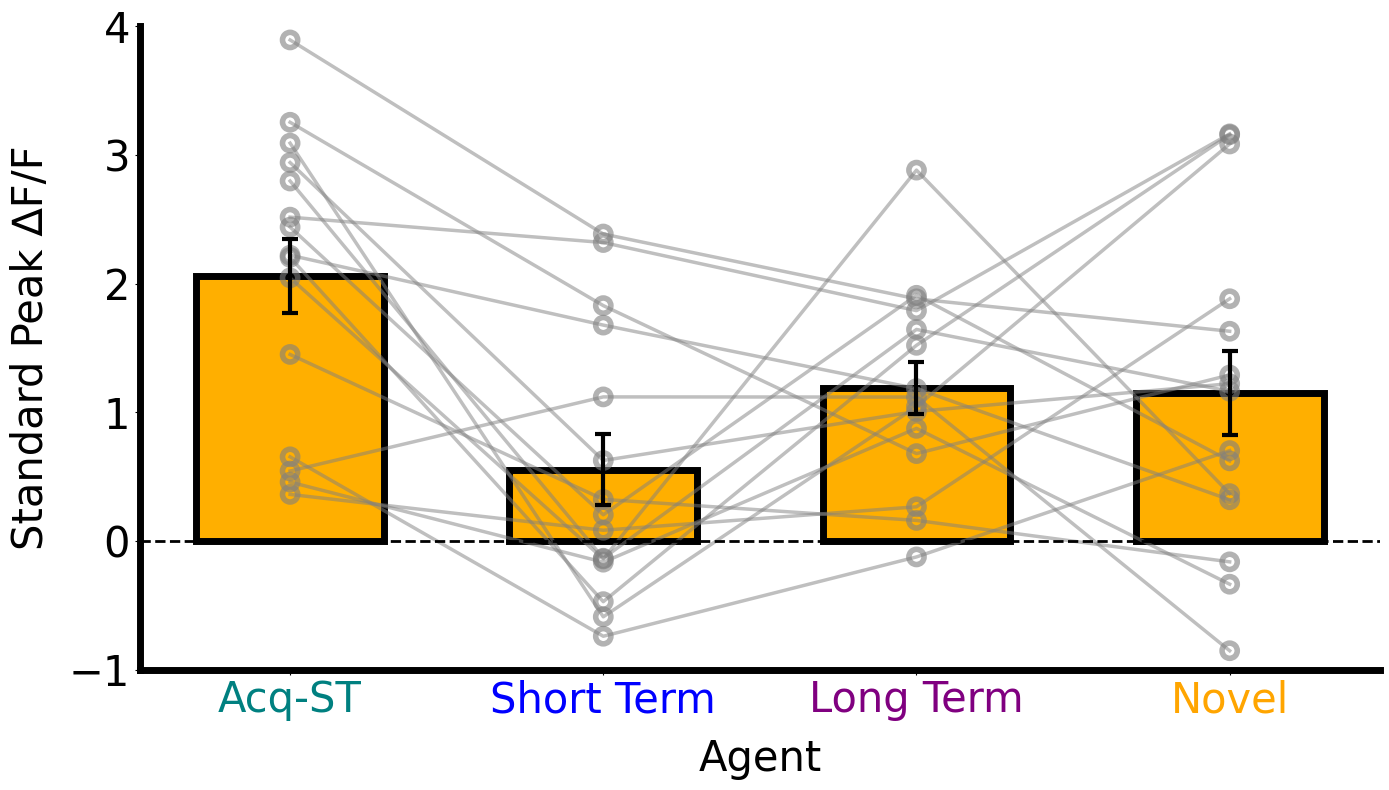


Paired t-test results:
                  comparison  n  t_stat  p_value  cohen_d
Short_Term-1 vs Short_Term-2 15  4.9697   0.0002   1.2832
 Short_Term-1 vs Long_Term-1 15  3.3120   0.0051   0.8552
     Short_Term-1 vs Novel-1 15  2.8840   0.0120   0.7446
 Short_Term-2 vs Long_Term-1 15 -2.0763   0.0568  -0.5361
     Short_Term-2 vs Novel-1 15 -1.4235   0.1765  -0.3676
      Long_Term-1 vs Novel-1 15  0.1081   0.9155   0.0279


In [24]:
mpfc_pivot_df, mpfc_stats_df = plot_behavior_across_bouts_no_identities(
    metadata_df=mpfc_ordered_df,
    y_col="Max Peak",
    ylabel="Standard Peak ∆F/F",
    xlabel="Agent",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-1, 4),
    yticks_increment=1,
    bar_color=mpfc_color,
    figsize=(14, 8),
    save=None,
    save_name ="mDA",
    title=None
)

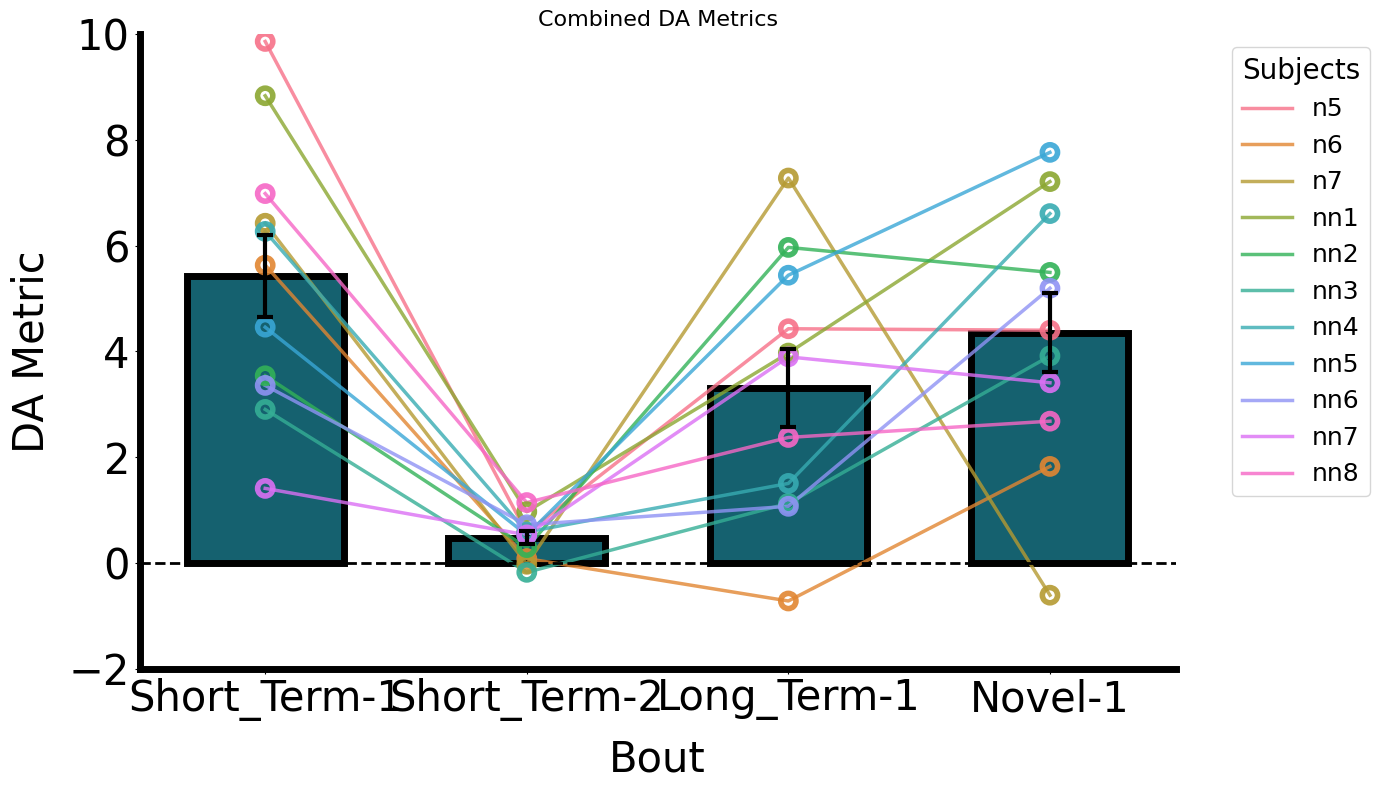

In [11]:
plot_behavior_across_bouts_with_identities(
    metadata_df=nac_ordered_df,
    y_col="Max Peak",
    title="Combined DA Metrics", 
    ylabel="DA Metric", 
    xlabel="Bout", 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=(-2,10), 
    bar_color=nac_color, 
    yticks_increment=None, 
    figsize=(14,8), 
    pad_inches=0.1,
    save=False,
    save_name=None
)

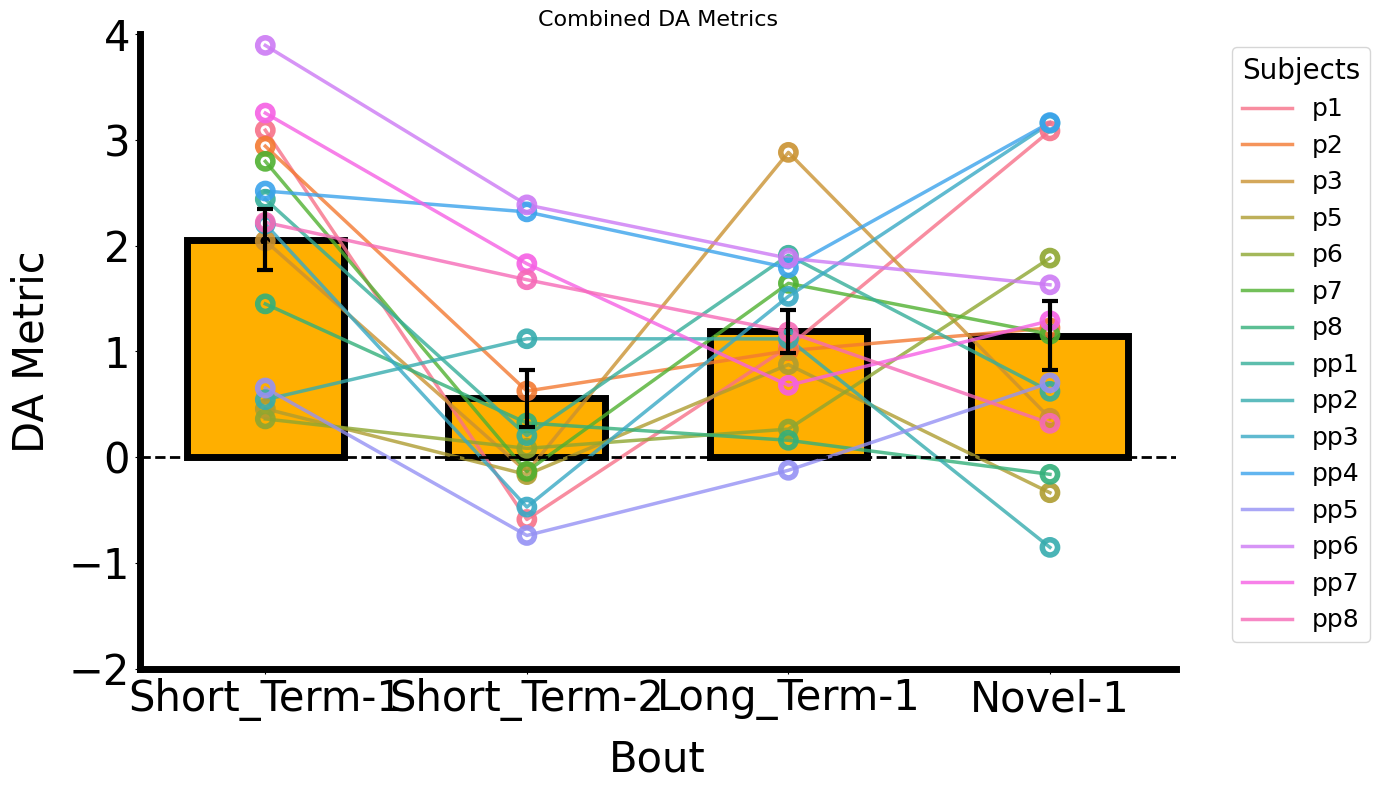

In [23]:
plot_behavior_across_bouts_with_identities(
    metadata_df=mpfc_ordered_df,
    y_col="Max Peak",
    title="Combined DA Metrics", 
    ylabel="DA Metric", 
    xlabel="Bout", 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=(-2,4), 
    bar_color=mpfc_color, 
    yticks_increment=None, 
    figsize=(14,8), 
    pad_inches=0.1,
    save=False,
    save_name=None
)

In [13]:
nac_exp.reset_all_behaviors()
nac_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)
nac_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

mpfc_exp.reset_all_behaviors()
mpfc_exp.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)
mpfc_exp.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

Processing behaviors for n5-240823-085032...
Processing behaviors for n6-240823-101436...
Processing behaviors for n7-240824-062103...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn2-250120-072910...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn4-250121-084228...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Computing DA metrics for n5-240823-085032 ...
Computing DA metrics for n6-240823-101436 ...
Computing DA metrics for n7-240824-062103 ...
Computing DA metrics for nn1-250120-063024 ...
Computing DA metrics for nn2-250120-072910 ...
Computing DA metrics for nn3-250121-074834 ...
Computing DA metrics for nn4-250121-084228 ...
Computing DA metrics for nn5-250120-081227 ...
Computing DA metrics for nn6-250120-085156 ...
Computing DA metrics for nn7-250121-094048 ...
Computing DA metrics for nn8-2

## DA across Subsequent Bouts

In [14]:
nac_exp_da_dict = get_trial_dataframes(nac_exp)
mpfc_exp_da_dict = get_trial_dataframes(mpfc_exp)

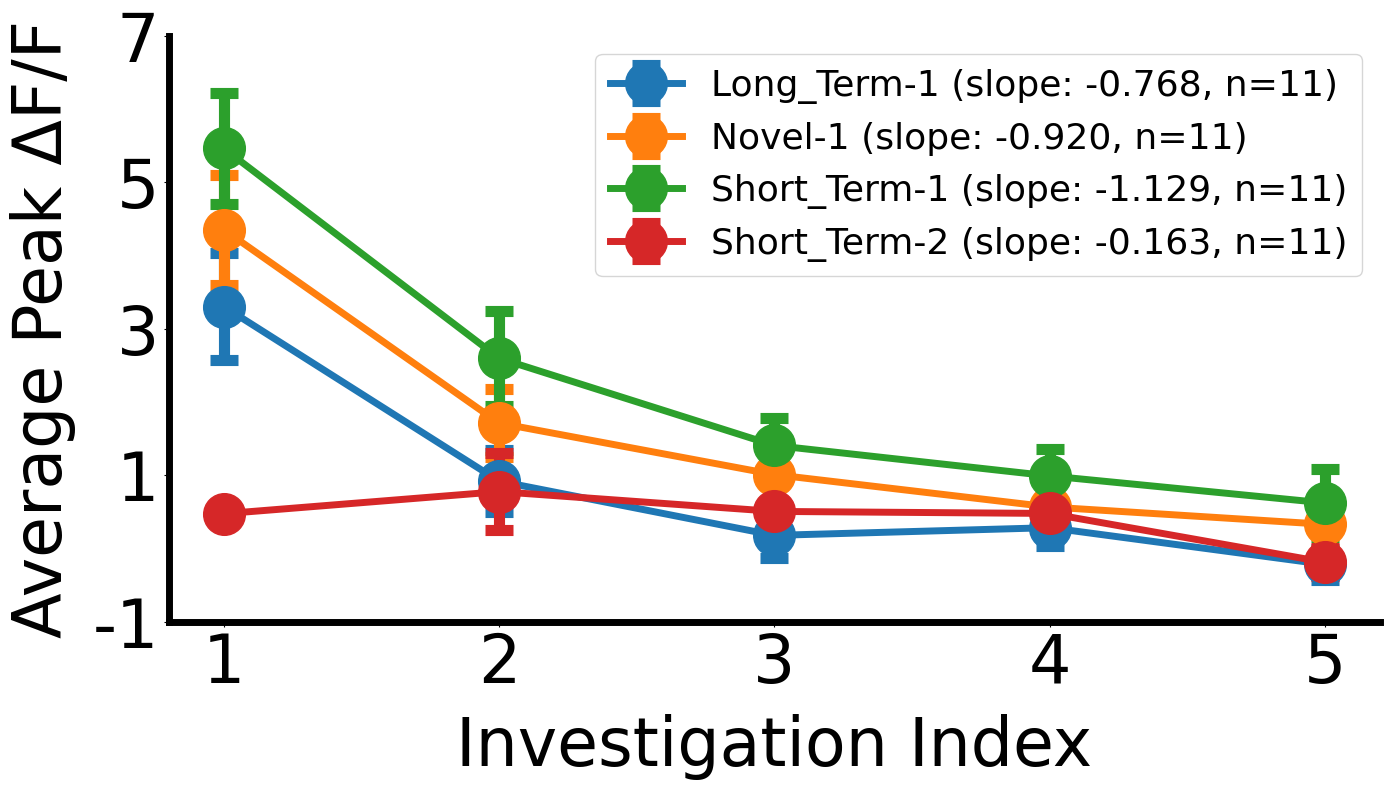


=== Computed Metric (SLOPE): ===
Bout: Long_Term-1, slope = -0.768
Bout: Novel-1, slope = -0.920
Bout: Short_Term-1, slope = -1.129
Bout: Short_Term-2, slope = -0.163


In [26]:
df = plot_peak_for_subsequent_behaviors(
    nac_exp_da_dict,
    behavior="Investigation",
    selected_bouts=["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"],
    n_subsequent_behaviors=5,
    peak_col="Max Peak",
    metric_type='slope', 
    xlabel="Investigation Index",
    ylabel="Average Peak ΔF/F",
    ylim=(-1, 7),
    ytick_increment=2,
    plot_title="",
    save = False,
    save_path=r"Home_Cage_Plots\mPFC_DA\peaks_for_subsequent_behaviors.png" 
)

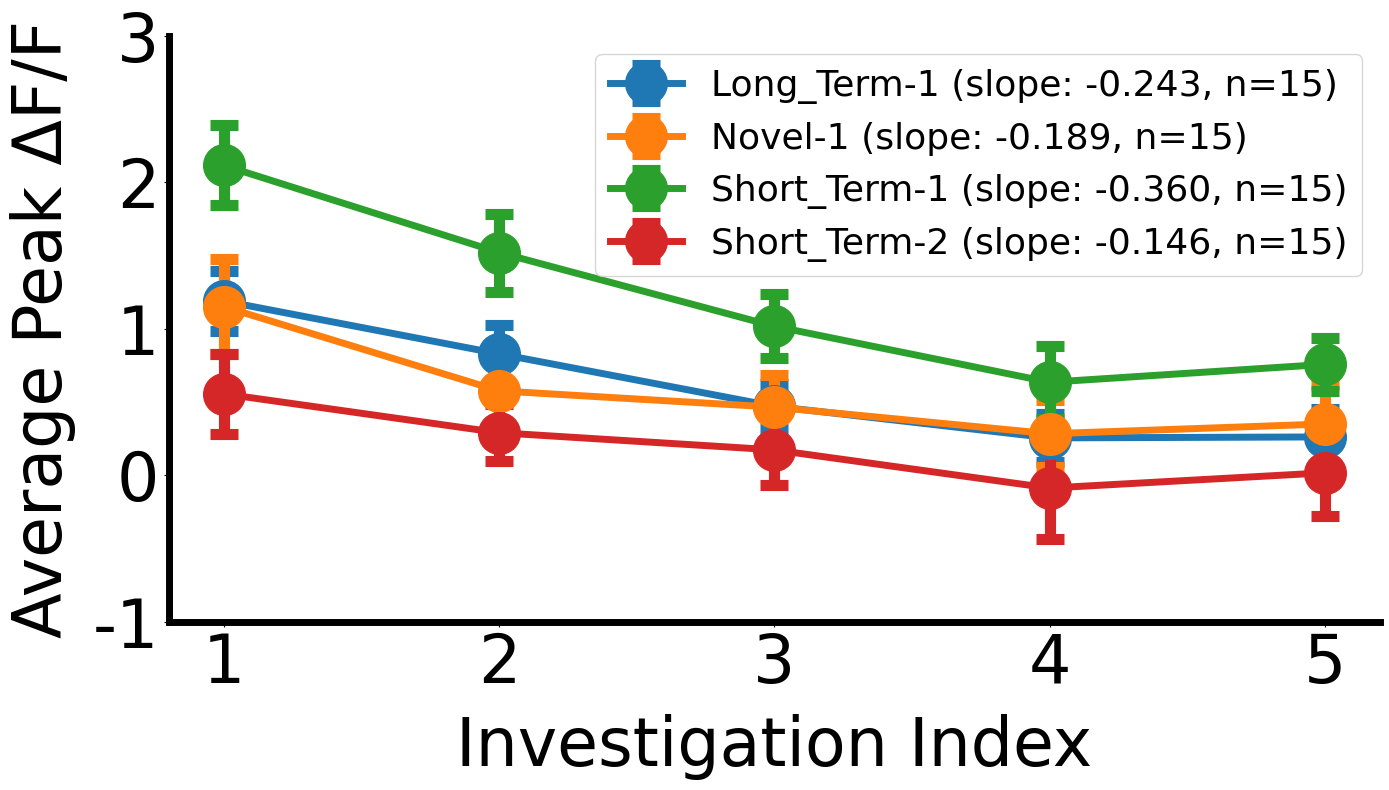


=== Computed Metric (SLOPE): ===
Bout: Long_Term-1, slope = -0.243
Bout: Novel-1, slope = -0.189
Bout: Short_Term-1, slope = -0.360
Bout: Short_Term-2, slope = -0.146


In [29]:
df = plot_peak_for_subsequent_behaviors(
    mpfc_exp_da_dict,
    behavior="Investigation",
    selected_bouts=["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"],
    n_subsequent_behaviors=5,
    peak_col="Max Peak",
    metric_type='slope', 
    xlabel="Investigation Index",
    ylabel="Average Peak ΔF/F",
    ylim=(-1, 3),
    ytick_increment=1,
    plot_title="",
    save = False,
    save_path=r"Home_Cage_Plots\mPFC_DA\peaks_for_subsequent_behaviors.png" 
)